In [6]:
import numpy as np
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance

In [7]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [8]:
from f_mean_adjust_ss_wasserstein_toad import (toad, compute_summaries, compute_summaries_stacked, mean_adjustment_summary_statistics, radial_flow, nf_transform)

## LOAD DATASET

In [9]:
true_theta = np.array([1.7, 35.0, 0.6])

In [10]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[   0.        ],
        [  27.71059636],
        [   0.        ],
        ...,
        [   0.        ],
        [  44.42188436],
        [  36.60917553]],

       [[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [  44.42188436],
        [  -5.66686451]],

       ...,

       [[-147.2341531 ],
        [  43.57896036],
        [ -21.3397667 ],
        ...,
        [  33.14338979],
        [  44.42188436],
        [  48.57785728]],

       [[-227.56086349],
        [  27.71059636],
        [   0.        ],
        ...,
        [  39.23219628],
        [ 160.8038917 ],
        [ 203.08908199]],

       [[ -33.11119055],
        [  27.71059636],
        [   0.        ],
        ...,
        [  45.63796568],
        [ 156.95883648],
        [ 157.96671617]]

In [11]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [12]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.87523209, 3.68776405, 6.33256945, 6.80461452, 3.9667474 ,
       6.27821639, 6.66568372, 4.00314105, 6.46787257, 6.59578051,
       4.00909721, 6.46736447])

## Training NF

In [13]:
len_ss = np.shape(actual_summary_statistics)[0]
wass_num_datasets = 1000
wass_val_num_datasets = 1000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 5
# To optimize F
tau = 0.1
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20

In [14]:
# Generating data to train the transform
wass_datasets = toad(true_theta[0], true_theta[1], true_theta[2],batch_size=wass_num_datasets)
wass_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [15]:
scaler_mean = np.mean(original_n_summary_statistics, axis=0)
scaler_std = np.std(original_n_summary_statistics, axis=0)

In [16]:
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [17]:
Lambda_list = np.load('Lambda_list_toad_tau.npy', allow_pickle=True)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [18]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

In [19]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    # Wasserstein transform
    transformed_summary_statistics = nf_transform(n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(transformed_summary_statistics).T)
    return sample_mean, sample_variance

def unbiased_log_likelihood(theta, actual_summary_statistics):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

In [20]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = ss_multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = ss_multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0, self.actual_summary_statistics) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = ss_multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q, self.actual_summary_statistics) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [21]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[6.87523209, 3.68776405, 6.33256945, 6.80461452, 3.9667474 ,
        6.27821639, 6.66568372, 4.00314105, 6.46787257, 6.59578051,
        4.00909721, 6.46736447]])

In [22]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = nf_transform(actual_summary_statistics)
transformed_summary_statistics[0]

array([-0.81530782, -0.12538951, -1.48551386,  1.48228239,  2.131922  ,
       -1.44417771, -0.59430013, -0.98174775,  0.97277947,  1.05682352,
       -0.78076476,  0.01819568])

In [23]:
nn_vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda = nn_vb.vb_posterior(stop)

  0%|          | 1/5000 [08:48<733:30:25, 528.23s/it]

LB -8699.533376388234


  0%|          | 2/5000 [16:44<690:53:13, 497.64s/it]

LB -8362.030667528144


  0%|          | 3/5000 [24:59<689:02:05, 496.40s/it]

LB -8554.207679736137


  0%|          | 4/5000 [33:20<691:30:19, 498.28s/it]

LB -7846.340140482424


  0%|          | 5/5000 [41:21<682:34:28, 491.95s/it]

LB -7754.726726675531


  0%|          | 6/5000 [49:08<670:44:24, 483.51s/it]

LB -7663.524470048341


  0%|          | 7/5000 [56:19<646:59:43, 466.49s/it]

LB -7190.683135026109


  0%|          | 8/5000 [1:04:24<655:05:42, 472.42s/it]

LB -7112.4204143369625


  0%|          | 9/5000 [1:13:04<675:16:15, 487.07s/it]

LB -6959.1230647375505


  0%|          | 10/5000 [1:21:27<681:55:19, 491.97s/it]

LB -6822.956298221546


  0%|          | 11/5000 [1:29:40<682:15:21, 492.31s/it]

LB -6978.913450411055


  0%|          | 12/5000 [1:37:45<679:07:36, 490.15s/it]

LB -7056.300704041181


  0%|          | 13/5000 [1:46:28<692:57:07, 500.23s/it]

LB -6184.584072071844


  0%|          | 14/5000 [1:56:10<726:53:13, 524.83s/it]

LB -5988.8061183685995


  0%|          | 15/5000 [2:02:50<674:27:27, 487.07s/it]

LB -6296.191117047867


  0%|          | 16/5000 [2:10:19<658:47:45, 475.86s/it]

LB -6080.823879703853


  0%|          | 17/5000 [2:18:27<663:31:56, 479.37s/it]

LB -5561.452180822154


  0%|          | 18/5000 [2:25:49<647:40:06, 468.01s/it]

LB -5737.421723378476


  0%|          | 19/5000 [2:33:06<634:59:17, 458.94s/it]

LB -5334.893944860585


  0%|          | 20/5000 [2:40:53<638:15:52, 461.40s/it]

LB -5251.358452192824


  0%|          | 21/5000 [2:48:04<625:27:20, 452.23s/it]

LB -4916.428052938904


  0%|          | 22/5000 [2:55:12<615:12:22, 444.91s/it]

LB -4877.356037900811


  0%|          | 23/5000 [3:03:13<629:51:47, 455.60s/it]

LB -4877.597577873701


  0%|          | 24/5000 [3:10:31<622:41:20, 450.50s/it]

LB -4562.2194803846


  0%|          | 25/5000 [3:18:40<638:12:49, 461.82s/it]

LB -4512.5379748908135


  1%|          | 26/5000 [3:26:21<638:02:43, 461.79s/it]

LB -4516.274541588619


  1%|          | 27/5000 [3:34:01<636:52:31, 461.04s/it]

LB -4036.6967787663993


  1%|          | 28/5000 [3:42:42<661:40:49, 479.09s/it]

LB -3862.0581709682697


  1%|          | 29/5000 [3:52:51<715:30:45, 518.17s/it]

LB -3949.350761195193


  1%|          | 30/5000 [4:03:02<753:45:38, 545.98s/it]

LB -3770.765549877981


  1%|          | 31/5000 [4:13:29<786:58:11, 570.15s/it]

LB -3661.5066478764593


  1%|          | 32/5000 [4:24:48<831:52:53, 602.81s/it]

LB -3817.3126374484436


  1%|          | 33/5000 [4:34:37<826:14:09, 598.84s/it]

LB -3576.7001681178353


  1%|          | 34/5000 [4:45:13<841:14:13, 609.84s/it]

LB -3303.673843757997


  1%|          | 35/5000 [4:55:24<841:34:00, 610.20s/it]

LB -3509.6245559014806


  1%|          | 36/5000 [5:03:03<779:03:51, 564.99s/it]

LB -3098.8485487987973


  1%|          | 37/5000 [5:10:39<733:54:03, 532.35s/it]

LB -3124.082242030291


  1%|          | 38/5000 [5:20:06<748:03:05, 542.72s/it]

LB -3009.787605730252


  1%|          | 39/5000 [5:30:10<773:03:16, 560.97s/it]

LB -3155.186564547261


  1%|          | 40/5000 [7:54:57<4131:39:12, 2998.78s/it]

LB -2841.3002036702765


  1%|          | 41/5000 [8:01:47<3060:54:28, 2222.07s/it]

LB -2781.582044897807


  1%|          | 42/5000 [8:08:48<2316:27:50, 1681.98s/it]

LB -2805.68323643007


  1%|          | 43/5000 [8:15:36<1789:28:07, 1299.59s/it]

LB -2653.5013071650674


  1%|          | 44/5000 [8:22:21<1419:49:07, 1031.35s/it]

LB -2592.7331590744743


  1%|          | 45/5000 [8:29:07<1161:21:18, 843.77s/it] 

LB -2502.7191985214536


  1%|          | 46/5000 [8:35:54<980:51:10, 712.77s/it] 

LB -2408.7234319511535


  1%|          | 47/5000 [8:42:40<854:04:14, 620.77s/it]

LB -2394.9006356279174


  1%|          | 48/5000 [8:49:37<769:48:14, 559.63s/it]

LB -2394.094376870489


  1%|          | 49/5000 [8:56:53<718:23:58, 522.37s/it]

LB -2164.426989495423


  1%|          | 50/5000 [9:04:15<685:08:33, 498.29s/it]

LB -2221.8093325629397


  1%|          | 51/5000 [9:11:23<655:53:54, 477.11s/it]

LB Smoothed -4706.86203870515


  1%|          | 52/5000 [9:18:11<627:29:43, 456.54s/it]

LB Smoothed -4581.926427170224


  1%|          | 53/5000 [9:25:04<609:17:42, 443.39s/it]

LB Smoothed -4447.332961760685


  1%|          | 54/5000 [9:32:04<599:34:52, 436.41s/it]

LB Smoothed -4329.3800531977295


  1%|          | 55/5000 [9:39:10<595:01:38, 433.18s/it]

LB Smoothed -4212.239813421118


  1%|          | 56/5000 [9:46:14<591:24:21, 430.64s/it]

LB Smoothed -4094.9881406326526


  1%|          | 57/5000 [9:53:23<590:31:14, 430.08s/it]

LB Smoothed -3984.9137564317543


  1%|          | 58/5000 [10:00:35<591:07:39, 430.61s/it]

LB Smoothed -3876.9110709406145


  1%|          | 59/5000 [10:07:54<594:22:11, 433.06s/it]

LB Smoothed -3770.8009791340423


  1%|          | 60/5000 [10:15:16<597:57:27, 435.76s/it]

LB Smoothed -3665.664245595706


  1%|          | 61/5000 [10:22:14<590:39:12, 430.52s/it]

LB Smoothed -3560.4848620115763


  1%|          | 62/5000 [10:29:14<586:13:45, 427.38s/it]

LB Smoothed -3450.879732207769


  1%|▏         | 63/5000 [10:36:35<591:36:28, 431.39s/it]

LB Smoothed -3357.3313252819603


  1%|▏         | 64/5000 [10:43:45<590:54:01, 430.96s/it]

LB Smoothed -3266.5214708282374


  1%|▏         | 65/5000 [10:50:40<584:21:32, 426.28s/it]

LB Smoothed -3168.8456188778764


  1%|▏         | 66/5000 [10:57:42<582:13:56, 424.81s/it]

LB Smoothed -3075.515979733202


  1%|▏         | 67/5000 [11:05:00<587:31:02, 428.76s/it]

LB Smoothed -2990.2007790489406


  1%|▏         | 68/5000 [11:12:18<591:15:25, 431.57s/it]

LB Smoothed -2898.835984710822


  1%|▏         | 69/5000 [11:19:28<590:31:41, 431.13s/it]

LB Smoothed -2816.9964616517104


  1%|▏         | 70/5000 [11:26:46<593:15:10, 433.21s/it]

LB Smoothed -2736.3250768065905


  1%|▏         | 71/5000 [11:33:42<586:05:22, 428.06s/it]

LB Smoothed -2660.519399846853


  1%|▏         | 72/5000 [11:40:46<584:26:40, 426.95s/it]

LB Smoothed -2586.959387019164


  1%|▏         | 73/5000 [11:48:07<590:10:02, 431.22s/it]

LB Smoothed -2509.898609074233


  1%|▏         | 74/5000 [11:55:14<587:57:00, 429.68s/it]

LB Smoothed -2440.99375059818


  2%|▏         | 75/5000 [12:02:20<586:25:05, 428.65s/it]

LB Smoothed -2372.8492584597543


  2%|▏         | 76/5000 [12:09:34<588:35:43, 430.33s/it]

LB Smoothed -2303.567760279551


  2%|▏         | 77/5000 [12:16:50<590:51:57, 432.08s/it]

LB Smoothed -2241.75237376722


  2%|▏         | 78/5000 [12:23:58<589:05:47, 430.87s/it]

LB Smoothed -2183.3724871030245


  2%|▏         | 79/5000 [12:31:12<590:09:56, 431.74s/it]

LB Smoothed -2123.7195857893676


  2%|▏         | 80/5000 [12:38:15<586:27:38, 429.12s/it]

LB Smoothed -2066.09280748443


  2%|▏         | 81/5000 [12:45:22<585:15:58, 428.33s/it]

LB Smoothed -2010.7976759286348


  2%|▏         | 82/5000 [12:52:32<585:52:44, 428.87s/it]

LB Smoothed -1952.5334216670726


  2%|▏         | 83/5000 [12:59:34<582:53:50, 426.77s/it]

LB Smoothed -1898.7035862787366


  2%|▏         | 84/5000 [13:06:30<578:41:55, 423.78s/it]

LB Smoothed -1847.693479694921


  2%|▏         | 85/5000 [13:13:29<576:21:35, 422.16s/it]

LB Smoothed -1793.8860028367342


  2%|▏         | 86/5000 [13:20:47<583:01:42, 427.13s/it]

LB Smoothed -1747.5788317262575


  2%|▏         | 87/5000 [13:27:59<584:36:28, 428.37s/it]

LB Smoothed -1699.855433632165


  2%|▏         | 88/5000 [13:35:11<585:57:50, 429.45s/it]

LB Smoothed -1653.7274379180485


  2%|▏         | 89/5000 [13:42:24<587:22:17, 430.57s/it]

LB Smoothed -1606.4807401887938


  2%|▏         | 90/5000 [13:49:39<589:02:08, 431.88s/it]

LB Smoothed -1563.0197872504777


  2%|▏         | 91/5000 [13:56:57<591:20:11, 433.65s/it]

LB Smoothed -1520.2185302780556


  2%|▏         | 92/5000 [14:04:15<593:11:21, 435.10s/it]

LB Smoothed -1475.7030502278503


  2%|▏         | 93/5000 [14:11:33<594:19:34, 436.03s/it]

LB Smoothed -1433.4178959033463


  2%|▏         | 94/5000 [14:18:53<595:48:29, 437.20s/it]

LB Smoothed -1393.577607698309


  2%|▏         | 95/5000 [14:26:28<603:01:18, 442.58s/it]

LB Smoothed -1355.0459270347621


  2%|▏         | 96/5000 [14:33:45<600:18:36, 440.68s/it]

LB Smoothed -1318.0267650149935


  2%|▏         | 97/5000 [14:40:48<592:59:07, 435.40s/it]

LB Smoothed -1281.0841858012925


  2%|▏         | 98/5000 [14:47:50<587:21:55, 431.36s/it]

LB Smoothed -1243.7435963984494


  2%|▏         | 99/5000 [14:55:08<589:55:22, 433.32s/it]

LB Smoothed -1209.5349584229327


  2%|▏         | 100/5000 [15:02:08<584:31:39, 429.45s/it]

LB Smoothed -1175.0372330080056


  2%|▏         | 101/5000 [15:09:13<582:35:35, 428.12s/it]

LB Smoothed -1139.8264588139182


  2%|▏         | 102/5000 [15:16:27<585:04:50, 430.03s/it]

LB Smoothed -1109.493125270553


  2%|▏         | 103/5000 [15:23:34<583:25:54, 428.91s/it]

LB Smoothed -1076.9269319688458


  2%|▏         | 104/5000 [15:30:57<589:09:31, 433.20s/it]

LB Smoothed -1045.4581635285497


  2%|▏         | 105/5000 [15:38:04<586:21:00, 431.23s/it]

LB Smoothed -1013.7444850296264


  2%|▏         | 106/5000 [15:45:04<581:57:02, 428.08s/it]

LB Smoothed -984.9119056862769


  2%|▏         | 107/5000 [15:52:17<583:31:26, 429.32s/it]

LB Smoothed -955.8941790855246


  2%|▏         | 108/5000 [15:59:30<585:12:59, 430.66s/it]

LB Smoothed -927.8544312213932


  2%|▏         | 109/5000 [16:06:40<584:33:04, 430.26s/it]

LB Smoothed -901.4971136009232


  2%|▏         | 110/5000 [16:13:52<585:12:55, 430.83s/it]

LB Smoothed -872.2547645751483


  2%|▏         | 111/5000 [16:20:53<581:16:33, 428.02s/it]

LB Smoothed -844.8253934035683


  2%|▏         | 112/5000 [16:28:07<583:19:17, 429.61s/it]

LB Smoothed -818.8172539839521


  2%|▏         | 113/5000 [16:35:21<585:20:12, 431.19s/it]

LB Smoothed -793.8478237592635


  2%|▏         | 114/5000 [16:42:20<579:53:08, 427.26s/it]

LB Smoothed -769.0997120373316


  2%|▏         | 115/5000 [16:49:18<576:00:35, 424.49s/it]

LB Smoothed -744.0597748590618


  2%|▏         | 116/5000 [16:56:29<578:53:31, 426.70s/it]

LB Smoothed -721.4869640473389


  2%|▏         | 117/5000 [17:03:42<581:13:51, 428.51s/it]

LB Smoothed -700.727182674517


  2%|▏         | 118/5000 [17:10:43<577:48:45, 426.08s/it]

LB Smoothed -678.438404873599


  2%|▏         | 119/5000 [17:17:54<579:49:18, 427.65s/it]

LB Smoothed -656.6488159857496


  2%|▏         | 120/5000 [17:24:54<576:41:32, 425.43s/it]

LB Smoothed -637.3648355437399


  2%|▏         | 121/5000 [17:32:08<579:48:21, 427.81s/it]

LB Smoothed -616.3744791220943


  2%|▏         | 122/5000 [17:39:18<580:48:22, 428.64s/it]

LB Smoothed -598.4669907078694


  2%|▏         | 123/5000 [17:46:16<576:12:11, 425.33s/it]

LB Smoothed -578.6074667092319


  2%|▏         | 124/5000 [17:53:21<576:10:54, 425.40s/it]

LB Smoothed -558.2096734458664


  2%|▎         | 125/5000 [18:00:27<576:19:20, 425.59s/it]

LB Smoothed -538.6461335014262


  3%|▎         | 126/5000 [18:07:26<573:13:18, 423.39s/it]

LB Smoothed -521.8071766109788


  3%|▎         | 127/5000 [18:14:28<572:54:34, 423.25s/it]

LB Smoothed -505.1222787376432


  3%|▎         | 128/5000 [18:21:45<578:08:35, 427.20s/it]

LB Smoothed -488.19752027370697


  3%|▎         | 129/5000 [18:28:47<575:49:54, 425.58s/it]

LB Smoothed -471.87932337153586


  3%|▎         | 130/5000 [18:35:59<578:30:38, 427.65s/it]

LB Smoothed -455.62907202275574


  3%|▎         | 131/5000 [18:43:23<584:55:07, 432.47s/it]

LB Smoothed -438.6435437816292


  3%|▎         | 132/5000 [18:50:42<587:26:55, 434.43s/it]

LB Smoothed -422.5304581916211


  3%|▎         | 133/5000 [18:57:52<585:34:05, 433.13s/it]

LB Smoothed -409.33354746165367


  3%|▎         | 134/5000 [19:05:04<585:07:11, 432.89s/it]

LB Smoothed -394.62772497178855


  3%|▎         | 135/5000 [19:12:20<586:13:32, 433.79s/it]

LB Smoothed -380.53965383176035


  3%|▎         | 136/5000 [19:19:26<582:44:42, 431.31s/it]

LB Smoothed -366.94774443829306


  3%|▎         | 137/5000 [19:26:45<586:03:06, 433.84s/it]

LB Smoothed -354.55853853131


  3%|▎         | 138/5000 [19:33:47<581:07:05, 430.28s/it]

LB Smoothed -340.21695734516004


  3%|▎         | 139/5000 [19:41:04<583:33:42, 432.18s/it]

LB Smoothed -328.49176018008


  3%|▎         | 140/5000 [19:47:52<573:44:56, 425.00s/it]

LB Smoothed -317.3291722429295


  3%|▎         | 141/5000 [19:54:36<564:55:19, 418.55s/it]

LB Smoothed -307.21628946778054


  3%|▎         | 142/5000 [20:01:14<556:45:59, 412.59s/it]

LB Smoothed -297.8148457358282


  3%|▎         | 143/5000 [20:08:23<562:59:07, 417.28s/it]

LB Smoothed -287.49208218691905


  3%|▎         | 144/5000 [20:15:22<563:29:35, 417.75s/it]

LB Smoothed -277.27288134447116


  3%|▎         | 145/5000 [20:22:07<558:21:59, 414.03s/it]

LB Smoothed -267.80072067219265


  3%|▎         | 146/5000 [20:29:07<560:35:40, 415.77s/it]

LB Smoothed -258.28622358682406


  3%|▎         | 147/5000 [20:36:09<563:08:58, 417.75s/it]

LB Smoothed -249.35270035754615


  3%|▎         | 148/5000 [20:43:13<565:24:11, 419.51s/it]

LB Smoothed -241.9687976435816


  3%|▎         | 149/5000 [20:50:08<563:41:42, 418.33s/it]

LB Smoothed -233.68602683152983


  3%|▎         | 150/5000 [20:57:09<564:42:23, 419.16s/it]

LB Smoothed -225.40487647427403


  3%|▎         | 151/5000 [21:04:07<563:51:00, 418.61s/it]

LB Smoothed -218.29234955913057


  3%|▎         | 152/5000 [21:11:06<564:09:03, 418.92s/it]

LB Smoothed -211.26693501214314


  3%|▎         | 153/5000 [21:18:17<568:50:48, 422.50s/it]

LB Smoothed -203.78123315870764


  3%|▎         | 154/5000 [21:24:59<560:21:51, 416.28s/it]

LB Smoothed -198.7977433453323


  3%|▎         | 155/5000 [21:31:39<553:34:11, 411.32s/it]

LB Smoothed -193.5178296758489


  3%|▎         | 156/5000 [21:38:39<557:00:21, 413.96s/it]

LB Smoothed -187.8744959839102


  3%|▎         | 157/5000 [21:45:50<563:39:33, 418.99s/it]

LB Smoothed -182.7328663334823


  3%|▎         | 158/5000 [21:52:39<559:48:06, 416.21s/it]

LB Smoothed -177.60395389929738


  3%|▎         | 159/5000 [21:59:41<561:48:43, 417.79s/it]

LB Smoothed -172.1218739110364


  3%|▎         | 160/5000 [22:06:31<558:38:59, 415.52s/it]

LB Smoothed -167.5390669600522


  3%|▎         | 161/5000 [22:13:23<557:08:48, 414.49s/it]

LB Smoothed -163.53680003396227


  3%|▎         | 162/5000 [22:20:16<556:18:06, 413.95s/it]

LB Smoothed -159.07844410472174


  3%|▎         | 163/5000 [22:27:04<553:50:26, 412.20s/it]

LB Smoothed -155.28694151927317


  3%|▎         | 164/5000 [22:33:51<551:50:42, 410.80s/it]

LB Smoothed -151.6147719204992


  3%|▎         | 165/5000 [22:40:42<551:32:30, 410.66s/it]

LB Smoothed -148.55927542643371


  3%|▎         | 166/5000 [22:47:45<556:19:15, 414.31s/it]

LB Smoothed -145.97172000659444


  3%|▎         | 167/5000 [22:54:43<557:46:31, 415.48s/it]

LB Smoothed -143.6246465826133


  3%|▎         | 168/5000 [23:01:28<553:38:05, 412.48s/it]

LB Smoothed -141.59039314366098


  3%|▎         | 169/5000 [23:08:26<555:49:17, 414.19s/it]

LB Smoothed -138.90722106315116


  3%|▎         | 170/5000 [23:15:29<558:58:17, 416.62s/it]

LB Smoothed -136.16896996732441


  3%|▎         | 171/5000 [23:22:24<558:25:36, 416.30s/it]

LB Smoothed -134.08842625556397


  3%|▎         | 172/5000 [23:29:09<553:43:15, 412.88s/it]

LB Smoothed -132.08682574503567


  3%|▎         | 173/5000 [23:35:55<550:45:44, 410.76s/it]

LB Smoothed -131.21002003880187


  3%|▎         | 174/5000 [23:42:33<545:28:28, 406.90s/it]

LB Smoothed -130.48280357858485


  4%|▎         | 175/5000 [23:50:26<571:55:56, 426.73s/it]

LB Smoothed -129.14525230812023


  4%|▎         | 176/5000 [23:57:29<570:32:29, 425.78s/it]

LB Smoothed -128.01804222210853


  4%|▎         | 177/5000 [24:04:26<566:36:45, 422.93s/it]

LB Smoothed -126.42667401984053


  4%|▎         | 178/5000 [24:11:30<566:53:11, 423.23s/it]

LB Smoothed -125.82172141844126


  4%|▎         | 179/5000 [24:18:13<558:56:01, 417.37s/it]

LB Smoothed -124.71908312679629


  4%|▎         | 180/5000 [24:24:59<554:09:27, 413.89s/it]

LB Smoothed -124.056529620583


  4%|▎         | 181/5000 [24:31:49<552:21:16, 412.63s/it]

LB Smoothed -123.11822768716021


  4%|▎         | 182/5000 [24:38:50<555:34:33, 415.13s/it]

LB Smoothed -122.19193025358622


  4%|▎         | 183/5000 [24:45:39<553:12:59, 413.45s/it]

LB Smoothed -121.2823081810203


  4%|▎         | 184/5000 [24:52:36<554:18:07, 414.35s/it]

LB Smoothed -120.625745296747


  4%|▎         | 185/5000 [24:59:21<550:41:37, 411.73s/it]

LB Smoothed -120.35930021976347


  4%|▎         | 186/5000 [25:06:03<546:27:51, 408.66s/it]

LB Smoothed -119.22982656589477


  4%|▎         | 187/5000 [25:12:41<542:03:38, 405.45s/it]

LB Smoothed -118.04721861860602


  4%|▍         | 188/5000 [25:19:21<539:58:17, 403.97s/it]

LB Smoothed -117.40935651465873


  4%|▍         | 189/5000 [25:26:02<538:31:07, 402.97s/it]

LB Smoothed -116.21607079649246


  4%|▍         | 190/5000 [25:32:57<543:04:49, 406.46s/it]

LB Smoothed -115.38716092378678


  4%|▍         | 191/5000 [25:39:56<547:57:18, 410.20s/it]

LB Smoothed -114.65318512356264


  4%|▍         | 192/5000 [25:46:51<549:53:50, 411.74s/it]

LB Smoothed -113.83330698186576


  4%|▍         | 193/5000 [25:53:53<553:49:02, 414.76s/it]

LB Smoothed -113.3485334265124


  4%|▍         | 194/5000 [26:01:08<562:06:42, 421.06s/it]

LB Smoothed -112.13332141956913


  4%|▍         | 195/5000 [26:08:00<558:03:04, 418.10s/it]

LB Smoothed -111.35321438320709


  4%|▍         | 196/5000 [26:15:04<560:33:21, 420.07s/it]

LB Smoothed -110.3984543019081


  4%|▍         | 197/5000 [26:22:09<562:09:53, 421.36s/it]

LB Smoothed -109.48841291202541


  4%|▍         | 198/5000 [26:29:09<561:29:56, 420.95s/it]

LB Smoothed -108.43752793340005


  4%|▍         | 199/5000 [26:35:55<555:32:41, 416.57s/it]

LB Smoothed -107.561214189675


  4%|▍         | 200/5000 [26:42:56<557:10:07, 417.88s/it]

LB Smoothed -106.66870778485804


  4%|▍         | 201/5000 [26:49:50<555:40:27, 416.84s/it]

LB Smoothed -105.5918640426202


  4%|▍         | 202/5000 [26:56:33<550:00:09, 412.67s/it]

LB Smoothed -104.86353057005915


  4%|▍         | 203/5000 [27:03:58<562:33:56, 422.19s/it]

LB Smoothed -103.84581024240735


  4%|▍         | 204/5000 [27:11:01<562:55:24, 422.54s/it]

LB Smoothed -102.75999943327159


  4%|▍         | 205/5000 [27:18:00<561:17:49, 421.41s/it]

LB Smoothed -101.49728287761059


  4%|▍         | 206/5000 [27:24:43<554:00:04, 416.02s/it]

LB Smoothed -99.98991223236436


  4%|▍         | 207/5000 [27:31:25<548:14:05, 411.78s/it]

LB Smoothed -98.62624067155666


  4%|▍         | 208/5000 [27:38:08<544:41:40, 409.20s/it]

LB Smoothed -97.50349735826917


  4%|▍         | 209/5000 [27:44:59<545:05:58, 409.59s/it]

LB Smoothed -96.53011948910014


  4%|▍         | 210/5000 [27:51:50<545:39:58, 410.10s/it]

LB Smoothed -95.14665123444641


  4%|▍         | 211/5000 [27:58:29<540:57:50, 406.65s/it]

LB Smoothed -94.3712485973491


  4%|▍         | 212/5000 [28:05:16<541:09:37, 406.89s/it]

LB Smoothed -93.2721492568314


  4%|▍         | 213/5000 [28:12:09<543:15:30, 408.55s/it]

LB Smoothed -92.43061598245356


  4%|▍         | 214/5000 [28:19:35<558:11:50, 419.87s/it]

LB Smoothed -91.19606424770117


  4%|▍         | 215/5000 [28:27:21<576:35:38, 433.80s/it]

LB Smoothed -90.06829611962601


  4%|▍         | 216/5000 [28:34:56<584:56:50, 440.18s/it]

LB Smoothed -88.94112590836444


  4%|▍         | 217/5000 [28:42:32<591:02:16, 444.85s/it]

LB Smoothed -87.55552259921934


  4%|▍         | 218/5000 [28:50:20<600:19:14, 451.94s/it]

LB Smoothed -86.31406848987803


  4%|▍         | 219/5000 [28:58:09<606:41:25, 456.83s/it]

LB Smoothed -85.35524339969123


  4%|▍         | 220/5000 [29:05:51<608:39:04, 458.40s/it]

LB Smoothed -84.30120166283005


  4%|▍         | 221/5000 [29:13:32<609:46:38, 459.34s/it]

LB Smoothed -83.1470187124219


  4%|▍         | 222/5000 [29:21:37<619:38:26, 466.87s/it]

LB Smoothed -81.84300045446334


  4%|▍         | 223/5000 [29:29:13<615:15:01, 463.66s/it]

LB Smoothed -80.48701863717373


  4%|▍         | 224/5000 [29:36:51<613:02:12, 462.09s/it]

LB Smoothed -79.43001493461337


  4%|▍         | 225/5000 [29:44:33<612:44:43, 461.97s/it]

LB Smoothed -78.07292606803317


  5%|▍         | 226/5000 [29:51:40<598:34:41, 451.38s/it]

LB Smoothed -76.9057840957203


  5%|▍         | 227/5000 [29:58:52<590:55:51, 445.71s/it]

LB Smoothed -75.63941650908926


  5%|▍         | 228/5000 [30:05:36<574:20:31, 433.28s/it]

LB Smoothed -74.80625579394706


  5%|▍         | 229/5000 [30:12:34<567:45:46, 428.41s/it]

LB Smoothed -74.01545692715902


  5%|▍         | 230/5000 [30:19:38<566:16:29, 427.38s/it]

LB Smoothed -73.06349064309929


  5%|▍         | 231/5000 [30:26:27<558:34:39, 421.66s/it]

LB Smoothed -71.93423959231455


  5%|▍         | 232/5000 [30:33:23<556:17:46, 420.02s/it]

LB Smoothed -70.84933254613408


  5%|▍         | 233/5000 [30:40:34<560:23:44, 423.21s/it]

LB Smoothed -69.7514888097941


  5%|▍         | 234/5000 [30:47:26<556:06:57, 420.06s/it]

LB Smoothed -68.71391731237125


  5%|▍         | 235/5000 [30:54:06<547:51:07, 413.91s/it]

LB Smoothed -68.10104720679749


  5%|▍         | 236/5000 [31:00:51<544:24:47, 411.40s/it]

LB Smoothed -67.510328278051


  5%|▍         | 237/5000 [31:07:45<545:10:11, 412.05s/it]

LB Smoothed -66.46147104804506


  5%|▍         | 238/5000 [31:14:57<552:45:29, 417.88s/it]

LB Smoothed -66.04299468285276


  5%|▍         | 239/5000 [31:21:47<549:37:34, 415.60s/it]

LB Smoothed -65.34178712052895


  5%|▍         | 240/5000 [31:28:44<549:57:41, 415.94s/it]

LB Smoothed -64.6248234314148


  5%|▍         | 241/5000 [31:35:43<551:05:49, 416.88s/it]

LB Smoothed -63.804942135036576


  5%|▍         | 242/5000 [31:42:38<550:28:54, 416.51s/it]

LB Smoothed -63.21817472150412


  5%|▍         | 243/5000 [31:49:19<543:59:11, 411.68s/it]

LB Smoothed -62.788217415124045


  5%|▍         | 244/5000 [31:55:59<539:12:17, 408.15s/it]

LB Smoothed -62.21708693052806


  5%|▍         | 245/5000 [32:02:45<538:27:58, 407.67s/it]

LB Smoothed -61.66406305619416


  5%|▍         | 246/5000 [32:09:34<538:57:19, 408.13s/it]

LB Smoothed -61.05527581940936


  5%|▍         | 247/5000 [32:16:40<545:36:59, 413.26s/it]

LB Smoothed -60.63112482156194


  5%|▍         | 248/5000 [32:23:24<541:50:07, 410.48s/it]

LB Smoothed -60.29840889262222


  5%|▍         | 249/5000 [32:30:10<540:19:23, 409.42s/it]

LB Smoothed -59.79042595426099


  5%|▌         | 250/5000 [32:37:28<551:21:16, 417.87s/it]

LB Smoothed -59.316808702511324


  5%|▌         | 251/5000 [32:44:52<561:29:49, 425.65s/it]

LB Smoothed -58.76210235819741


  5%|▌         | 252/5000 [32:52:02<563:02:38, 426.91s/it]

LB Smoothed -58.31016773685691


  5%|▌         | 253/5000 [32:58:52<556:21:22, 421.93s/it]

LB Smoothed -57.84160063426953


  5%|▌         | 254/5000 [33:05:39<550:17:42, 417.42s/it]

LB Smoothed -57.731164376429035


  5%|▌         | 255/5000 [33:12:28<547:02:37, 415.04s/it]

LB Smoothed -57.39704801419942


  5%|▌         | 256/5000 [33:19:31<550:06:09, 417.45s/it]

LB Smoothed -57.15457874419072


  5%|▌         | 257/5000 [33:26:21<546:49:36, 415.05s/it]

LB Smoothed -56.614635395182745


  5%|▌         | 258/5000 [33:33:09<543:51:25, 412.88s/it]

LB Smoothed -56.12480826544008


  5%|▌         | 259/5000 [33:39:59<542:51:26, 412.21s/it]

LB Smoothed -55.93864899251285


  5%|▌         | 260/5000 [33:47:35<560:01:47, 425.34s/it]

LB Smoothed -55.77540864694373


  5%|▌         | 261/5000 [33:54:53<564:42:27, 428.98s/it]

LB Smoothed -55.68466878279156


  5%|▌         | 262/5000 [34:02:07<566:42:20, 430.59s/it]

LB Smoothed -55.44431418081216


  5%|▌         | 263/5000 [34:09:12<564:25:33, 428.95s/it]

LB Smoothed -55.08375801019366


  5%|▌         | 264/5000 [34:16:11<560:12:01, 425.83s/it]

LB Smoothed -54.75715907646133


  5%|▌         | 265/5000 [34:23:28<564:39:13, 429.30s/it]

LB Smoothed -54.459284821848236


  5%|▌         | 266/5000 [34:30:29<561:09:31, 426.74s/it]

LB Smoothed -54.09785959969355


  5%|▌         | 267/5000 [34:37:33<559:52:41, 425.85s/it]

LB Smoothed -53.69850887656506


  5%|▌         | 268/5000 [34:44:36<558:42:13, 425.05s/it]

LB Smoothed -53.322983433990075


  5%|▌         | 269/5000 [34:51:36<556:47:53, 423.69s/it]

LB Smoothed -52.78267578658968


  5%|▌         | 270/5000 [34:58:37<555:35:17, 422.86s/it]

LB Smoothed -52.60730167035674


  5%|▌         | 271/5000 [35:05:34<552:52:57, 420.89s/it]

LB Smoothed -52.210385536898436


  5%|▌         | 272/5000 [35:12:28<549:59:45, 418.78s/it]

LB Smoothed -52.00046250098921


  5%|▌         | 273/5000 [35:19:24<548:46:29, 417.94s/it]

LB Smoothed -51.87788622339664


  5%|▌         | 274/5000 [35:26:36<554:21:47, 422.28s/it]

LB Smoothed -51.56266770422095


  6%|▌         | 275/5000 [35:33:28<550:16:16, 419.25s/it]

LB Smoothed -51.38430889898095


  6%|▌         | 276/5000 [35:40:24<548:59:58, 418.37s/it]

LB Smoothed -51.26557017396957


  6%|▌         | 277/5000 [35:47:18<547:08:48, 417.05s/it]

LB Smoothed -51.02323730042353


  6%|▌         | 278/5000 [35:54:15<546:42:43, 416.81s/it]

LB Smoothed -51.08314186454693


  6%|▌         | 279/5000 [36:01:08<545:05:56, 415.67s/it]

LB Smoothed -50.8427229809093


  6%|▌         | 280/5000 [36:08:05<545:34:09, 416.11s/it]

LB Smoothed -50.643396450498464


  6%|▌         | 281/5000 [36:14:58<544:15:49, 415.20s/it]

LB Smoothed -50.590707665845876


  6%|▌         | 282/5000 [36:21:51<543:20:18, 414.59s/it]

LB Smoothed -50.46874505838461


  6%|▌         | 283/5000 [36:28:58<548:11:46, 418.38s/it]

LB Smoothed -50.22188782951673


  6%|▌         | 284/5000 [36:35:52<546:13:04, 416.96s/it]

LB Smoothed -50.052123994051875


  6%|▌         | 285/5000 [36:42:50<546:23:43, 417.18s/it]

LB Smoothed -49.90904656040909


  6%|▌         | 286/5000 [36:49:44<545:05:44, 416.28s/it]

LB Smoothed -49.702352823778675


  6%|▌         | 287/5000 [36:56:35<542:56:55, 414.73s/it]

LB Smoothed -49.370295721159046


  6%|▌         | 288/5000 [37:03:27<541:46:20, 413.92s/it]

LB Smoothed -49.24238212217212


  6%|▌         | 289/5000 [37:10:17<539:57:35, 412.62s/it]

LB Smoothed -49.12564419921954


  6%|▌         | 290/5000 [37:17:08<539:27:28, 412.32s/it]

LB Smoothed -48.99311574548081


  6%|▌         | 291/5000 [37:24:01<539:30:31, 412.45s/it]

LB Smoothed -48.75102456074838


  6%|▌         | 292/5000 [37:31:01<542:30:36, 414.83s/it]

LB Smoothed -48.60675143679803


  6%|▌         | 293/5000 [37:37:58<543:09:12, 415.41s/it]

LB Smoothed -48.42540158237831


  6%|▌         | 294/5000 [37:44:53<542:42:19, 415.16s/it]

LB Smoothed -48.20310200416701


  6%|▌         | 295/5000 [37:51:44<541:00:46, 413.95s/it]

LB Smoothed -48.04015489867552


  6%|▌         | 296/5000 [37:58:37<540:43:34, 413.82s/it]

LB Smoothed -47.865807285966824


  6%|▌         | 297/5000 [38:05:31<540:23:56, 413.66s/it]

LB Smoothed -47.68610432775434


  6%|▌         | 298/5000 [38:12:20<538:35:31, 412.36s/it]

LB Smoothed -47.57453640581647


  6%|▌         | 299/5000 [38:19:11<538:00:45, 412.01s/it]

LB Smoothed -47.49843773294364


  6%|▌         | 300/5000 [38:26:05<538:34:01, 412.52s/it]

LB Smoothed -47.5590784665835


  6%|▌         | 301/5000 [38:33:02<540:25:02, 414.02s/it]

LB Smoothed -47.38996836578138


  6%|▌         | 302/5000 [38:40:02<542:26:42, 415.67s/it]

LB Smoothed -47.300780486748984


  6%|▌         | 303/5000 [38:46:55<541:16:03, 414.85s/it]

LB Smoothed -47.145370183454276


  6%|▌         | 304/5000 [38:53:47<539:57:10, 413.93s/it]

LB Smoothed -47.22058739346273


  6%|▌         | 305/5000 [39:00:38<538:58:49, 413.28s/it]

LB Smoothed -47.04370859217873


  6%|▌         | 306/5000 [39:07:31<538:42:38, 413.16s/it]

LB Smoothed -47.12350273775423


  6%|▌         | 307/5000 [39:14:34<542:21:06, 416.04s/it]

LB Smoothed -47.05504295367369


  6%|▌         | 308/5000 [39:21:02<531:24:35, 407.73s/it]

LB Smoothed -46.84274611665306


  6%|▌         | 309/5000 [39:27:32<524:04:27, 402.19s/it]

LB Smoothed -46.65938924446928


  6%|▌         | 310/5000 [39:33:56<517:03:51, 396.89s/it]

LB Smoothed -46.50480659324616


  6%|▌         | 311/5000 [39:40:36<517:55:54, 397.64s/it]

LB Smoothed -46.394629027891405


  6%|▌         | 312/5000 [39:47:10<516:27:14, 396.59s/it]

LB Smoothed -46.31519755855752


  6%|▋         | 313/5000 [39:53:43<514:56:03, 395.51s/it]

LB Smoothed -46.240353058932044


  6%|▋         | 314/5000 [40:00:24<517:16:56, 397.40s/it]

LB Smoothed -46.12622768154004


  6%|▋         | 315/5000 [40:07:02<517:02:29, 397.30s/it]

LB Smoothed -46.03644486379817


  6%|▋         | 316/5000 [40:13:37<516:21:48, 396.86s/it]

LB Smoothed -45.88829864114589


  6%|▋         | 317/5000 [40:20:12<515:23:24, 396.20s/it]

LB Smoothed -45.76412959456087


  6%|▋         | 318/5000 [40:26:38<511:18:52, 393.15s/it]

LB Smoothed -45.75156407397117


  6%|▋         | 319/5000 [40:33:05<508:56:49, 391.41s/it]

LB Smoothed -45.554224433378444


  6%|▋         | 320/5000 [40:39:44<511:36:53, 393.55s/it]

LB Smoothed -45.420116901841084


  6%|▋         | 321/5000 [40:46:23<513:42:25, 395.24s/it]

LB Smoothed -45.14580669537438


  6%|▋         | 322/5000 [40:52:51<510:51:58, 393.14s/it]

LB Smoothed -44.78774969664258


  6%|▋         | 323/5000 [40:59:21<509:17:03, 392.01s/it]

LB Smoothed -44.72079640439854


  6%|▋         | 324/5000 [41:06:03<513:12:51, 395.12s/it]

LB Smoothed -44.47599407517792


  6%|▋         | 325/5000 [41:12:31<510:15:25, 392.93s/it]

LB Smoothed -44.31418136398586


  7%|▋         | 326/5000 [41:19:01<508:51:19, 391.93s/it]

LB Smoothed -44.13273396511231


  7%|▋         | 327/5000 [41:25:29<507:17:23, 390.81s/it]

LB Smoothed -43.7242576178862


  7%|▋         | 328/5000 [41:31:58<506:38:00, 390.39s/it]

LB Smoothed -43.580481052325325


  7%|▋         | 329/5000 [41:38:24<504:46:26, 389.04s/it]

LB Smoothed -43.449550320071715


  7%|▋         | 330/5000 [41:45:05<509:14:40, 392.57s/it]

LB Smoothed -43.17221255429994


  7%|▋         | 331/5000 [41:51:51<514:28:08, 396.68s/it]

LB Smoothed -42.98454760236303


  7%|▋         | 332/5000 [41:58:18<510:31:02, 393.72s/it]

LB Smoothed -42.918966857865016


  7%|▋         | 333/5000 [42:04:49<509:20:54, 392.90s/it]

LB Smoothed -42.741417755146756


  7%|▋         | 334/5000 [42:11:17<507:21:16, 391.44s/it]

LB Smoothed -42.569037178131055


  7%|▋         | 335/5000 [42:17:45<505:54:21, 390.41s/it]

LB Smoothed -42.55869216744281


  7%|▋         | 336/5000 [42:24:22<508:16:48, 392.33s/it]

LB Smoothed -42.52180155032945


  7%|▋         | 337/5000 [42:31:25<520:10:38, 401.60s/it]

LB Smoothed -42.40793762996789


  7%|▋         | 338/5000 [42:38:29<528:39:30, 408.23s/it]

LB Smoothed -42.387783714152945


  7%|▋         | 339/5000 [42:45:30<533:43:53, 412.24s/it]

LB Smoothed -42.34174712394959


  7%|▋         | 340/5000 [42:53:11<552:18:00, 426.67s/it]

LB Smoothed -42.25034480001762


  7%|▋         | 341/5000 [43:00:33<558:23:34, 431.47s/it]

LB Smoothed -42.13293024520845


  7%|▋         | 342/5000 [43:08:21<572:20:59, 442.35s/it]

LB Smoothed -42.0860679994142


  7%|▋         | 343/5000 [43:15:45<572:48:16, 442.80s/it]

LB Smoothed -42.074471283138465


  7%|▋         | 344/5000 [43:22:46<564:18:43, 436.32s/it]

LB Smoothed -42.028081924853325


  7%|▋         | 345/5000 [43:29:46<557:45:02, 431.34s/it]

LB Smoothed -42.00988456275487


  7%|▋         | 346/5000 [43:36:40<551:04:30, 426.27s/it]

LB Smoothed -41.873811477543775


  7%|▋         | 347/5000 [43:43:36<547:02:21, 423.24s/it]

LB Smoothed -41.6301277950566


  7%|▋         | 348/5000 [43:51:00<554:56:26, 429.45s/it]

LB Smoothed -41.43206950030512


  7%|▋         | 349/5000 [43:57:44<544:48:29, 421.70s/it]

LB Smoothed -41.256035379623874


  7%|▋         | 350/5000 [44:04:22<535:32:21, 414.61s/it]

LB Smoothed -41.28471052831193


  7%|▋         | 351/5000 [44:10:53<526:15:00, 407.51s/it]

LB Smoothed -41.18845386513722


  7%|▋         | 352/5000 [44:17:19<517:39:09, 400.94s/it]

LB Smoothed -40.9926891438858


  7%|▋         | 353/5000 [44:23:45<512:07:24, 396.74s/it]

LB Smoothed -40.795925037586


  7%|▋         | 354/5000 [44:30:13<508:36:26, 394.10s/it]

LB Smoothed -40.85876918653376


  7%|▋         | 355/5000 [44:36:33<502:42:29, 389.61s/it]

LB Smoothed -40.79444708030528


  7%|▋         | 356/5000 [44:42:54<499:32:24, 387.24s/it]

LB Smoothed -40.72514491454093


  7%|▋         | 357/5000 [44:49:17<497:53:02, 386.04s/it]

LB Smoothed -40.66561356324327


  7%|▋         | 358/5000 [44:55:55<502:03:26, 389.36s/it]

LB Smoothed -40.54009712823966


  7%|▋         | 359/5000 [45:02:20<500:14:16, 388.03s/it]

LB Smoothed -40.448413697014686


  7%|▋         | 360/5000 [45:08:45<499:10:29, 387.29s/it]

LB Smoothed -40.36229739397229


  7%|▋         | 361/5000 [45:15:10<498:18:11, 386.70s/it]

LB Smoothed -40.22329654555335


  7%|▋         | 362/5000 [45:21:35<497:29:16, 386.15s/it]

LB Smoothed -40.24045493019202


  7%|▋         | 363/5000 [45:28:00<496:41:42, 385.62s/it]

LB Smoothed -40.2652464917509


  7%|▋         | 364/5000 [45:34:23<495:38:41, 384.88s/it]

LB Smoothed -40.24193704798515


  7%|▋         | 365/5000 [45:40:46<494:47:09, 384.30s/it]

LB Smoothed -40.254876445594654


  7%|▋         | 366/5000 [45:47:10<494:39:18, 384.28s/it]

LB Smoothed -40.373264977314655


  7%|▋         | 367/5000 [45:53:32<493:35:42, 383.54s/it]

LB Smoothed -40.27759720653865


  7%|▋         | 368/5000 [46:00:20<502:50:09, 390.81s/it]

LB Smoothed -40.309330961516636


  7%|▋         | 369/5000 [46:06:49<502:22:21, 390.53s/it]

LB Smoothed -40.239474677231385


  7%|▋         | 370/5000 [46:13:13<499:24:53, 388.31s/it]

LB Smoothed -40.26353821813057


  7%|▋         | 371/5000 [46:19:34<496:39:46, 386.26s/it]

LB Smoothed -40.215113525867146


  7%|▋         | 372/5000 [46:26:21<504:41:58, 392.59s/it]

LB Smoothed -40.09623379331675


  7%|▋         | 373/5000 [46:33:13<511:49:18, 398.22s/it]

LB Smoothed -40.018390649695355


  7%|▋         | 374/5000 [46:40:06<517:21:57, 402.62s/it]

LB Smoothed -39.99431765154529


  8%|▊         | 375/5000 [46:46:57<520:35:13, 405.21s/it]

LB Smoothed -39.9434727419067


  8%|▊         | 376/5000 [46:54:06<529:37:05, 412.33s/it]

LB Smoothed -39.914876292814895


  8%|▊         | 377/5000 [47:01:30<541:46:53, 421.89s/it]

LB Smoothed -39.96242473250778


  8%|▊         | 378/5000 [47:08:02<530:02:09, 412.84s/it]

LB Smoothed -40.03611478995456


  8%|▊         | 379/5000 [47:14:44<525:40:39, 409.53s/it]

LB Smoothed -40.040596597142596


  8%|▊         | 380/5000 [47:21:31<524:51:01, 408.97s/it]

LB Smoothed -40.065906918938765


  8%|▊         | 381/5000 [47:28:29<528:15:12, 411.72s/it]

LB Smoothed -40.04571955210056


  8%|▊         | 382/5000 [47:35:34<533:04:14, 415.56s/it]

LB Smoothed -39.96123851339604


  8%|▊         | 383/5000 [47:42:34<534:40:00, 416.89s/it]

LB Smoothed -40.141982564118884


  8%|▊         | 384/5000 [47:49:37<537:07:01, 418.90s/it]

LB Smoothed -40.15439450142359


  8%|▊         | 385/5000 [47:56:38<537:44:21, 419.47s/it]

LB Smoothed -40.13877514006302


  8%|▊         | 386/5000 [48:04:00<546:18:54, 426.25s/it]

LB Smoothed -40.168012265025325


  8%|▊         | 387/5000 [48:11:00<543:43:33, 424.33s/it]

LB Smoothed -40.15101140161757


  8%|▊         | 388/5000 [48:18:01<542:06:48, 423.16s/it]

LB Smoothed -40.101428932660696


  8%|▊         | 389/5000 [48:25:00<540:28:14, 421.97s/it]

LB Smoothed -40.039169009752285


  8%|▊         | 390/5000 [48:32:02<540:17:51, 421.92s/it]

LB Smoothed -40.10092542270121


  8%|▊         | 391/5000 [48:39:04<540:22:51, 422.08s/it]

LB Smoothed -39.96847946262519


  8%|▊         | 392/5000 [48:46:13<542:49:10, 424.08s/it]

LB Smoothed -39.88860298032842


  8%|▊         | 393/5000 [48:54:08<562:23:12, 439.46s/it]

LB Smoothed -39.77397671379509


  8%|▊         | 394/5000 [49:03:11<601:55:27, 470.46s/it]

LB Smoothed -39.727931993290014


  8%|▊         | 395/5000 [49:14:40<685:49:38, 536.15s/it]

LB Smoothed -39.81710204386643


  8%|▊         | 396/5000 [49:24:54<715:13:01, 559.25s/it]

LB Smoothed -39.89841116268871


  8%|▊         | 397/5000 [49:32:39<679:07:35, 531.14s/it]

LB Smoothed -39.971959350201445


  8%|▊         | 398/5000 [49:40:05<646:26:04, 505.69s/it]

LB Smoothed -40.01009695857141


  8%|▊         | 399/5000 [49:46:44<605:24:25, 473.69s/it]

LB Smoothed -39.99266371339839


  8%|▊         | 400/5000 [49:53:15<573:17:13, 448.66s/it]

LB Smoothed -39.914180640259985


  8%|▊         | 401/5000 [49:59:50<552:45:47, 432.69s/it]

LB Smoothed -39.944664059526815


  8%|▊         | 402/5000 [50:06:23<537:13:58, 420.63s/it]

LB Smoothed -39.92974366213789


  8%|▊         | 403/5000 [50:13:09<531:30:44, 416.24s/it]

LB Smoothed -39.855847578213606


  8%|▊         | 404/5000 [50:19:43<523:10:40, 409.80s/it]

LB Smoothed -39.79993331097292


  8%|▊         | 405/5000 [50:26:19<517:41:28, 405.59s/it]

LB Smoothed -39.780146150265644


  8%|▊         | 406/5000 [50:32:51<512:15:29, 401.42s/it]

LB Smoothed -39.741258161380614


  8%|▊         | 407/5000 [50:39:29<510:44:38, 400.32s/it]

LB Smoothed -39.760016687719705


  8%|▊         | 408/5000 [50:46:05<509:19:16, 399.29s/it]

LB Smoothed -39.83032916114543


  8%|▊         | 409/5000 [50:52:49<510:57:36, 400.67s/it]

LB Smoothed -39.85466071567254


  8%|▊         | 410/5000 [51:00:44<539:10:31, 422.88s/it]

LB Smoothed -39.94065101883208


  8%|▊         | 411/5000 [51:07:53<541:14:55, 424.60s/it]

LB Smoothed -39.88094975276198


  8%|▊         | 412/5000 [51:14:36<532:52:17, 418.12s/it]

LB Smoothed -39.81143364213736


  8%|▊         | 413/5000 [51:21:10<523:29:07, 410.85s/it]

LB Smoothed -39.80397587831934


  8%|▊         | 414/5000 [51:27:46<517:42:25, 406.40s/it]

LB Smoothed -39.786291170673664


  8%|▊         | 415/5000 [51:34:18<512:23:56, 402.32s/it]

LB Smoothed -39.6570189980295


  8%|▊         | 416/5000 [51:40:54<509:43:45, 400.31s/it]

LB Smoothed -39.73167686113716


  8%|▊         | 417/5000 [51:47:25<505:55:02, 397.40s/it]

LB Smoothed -39.63496749723019


  8%|▊         | 418/5000 [51:53:52<502:02:43, 394.45s/it]

LB Smoothed -39.67225525074592


  8%|▊         | 419/5000 [52:00:23<500:25:27, 393.26s/it]

LB Smoothed -39.69172502336497


  8%|▊         | 420/5000 [52:06:56<500:23:01, 393.31s/it]

LB Smoothed -39.74899706723129


  8%|▊         | 421/5000 [52:13:32<501:08:48, 394.00s/it]

LB Smoothed -39.80084559698831


  8%|▊         | 422/5000 [52:20:18<505:48:33, 397.75s/it]

LB Smoothed -39.74886002015015


  8%|▊         | 423/5000 [52:26:53<504:43:09, 396.98s/it]

LB Smoothed -39.72693873592915


  8%|▊         | 424/5000 [52:33:40<508:07:05, 399.74s/it]

LB Smoothed -39.743620314312466


  8%|▊         | 425/5000 [52:40:11<504:48:52, 397.23s/it]

LB Smoothed -39.70859653088971


  9%|▊         | 426/5000 [52:46:49<505:01:35, 397.48s/it]

LB Smoothed -39.665514226783316


  9%|▊         | 427/5000 [52:54:32<529:42:41, 417.00s/it]

LB Smoothed -39.49823630122231


  9%|▊         | 428/5000 [53:01:38<533:05:17, 419.75s/it]

LB Smoothed -39.499447198096924


  9%|▊         | 429/5000 [53:08:03<519:43:26, 409.32s/it]

LB Smoothed -39.50810934626997


  9%|▊         | 430/5000 [53:15:43<539:11:53, 424.75s/it]

LB Smoothed -39.56170791253819


  9%|▊         | 431/5000 [53:23:50<562:46:15, 443.42s/it]

LB Smoothed -39.68563849377244


  9%|▊         | 432/5000 [53:31:46<574:45:32, 452.96s/it]

LB Smoothed -39.49079103678404


  9%|▊         | 433/5000 [53:39:45<584:37:21, 460.84s/it]

LB Smoothed -39.35128680068032


  9%|▊         | 434/5000 [53:47:46<592:13:14, 466.93s/it]

LB Smoothed -39.30897228585614


  9%|▊         | 435/5000 [53:55:38<594:07:12, 468.53s/it]

LB Smoothed -39.21516712914156


  9%|▊         | 436/5000 [54:03:32<595:48:54, 469.97s/it]

LB Smoothed -39.105241177992994


  9%|▊         | 437/5000 [54:09:59<564:05:11, 445.04s/it]

LB Smoothed -38.949116830294


  9%|▉         | 438/5000 [54:16:00<532:00:33, 419.82s/it]

LB Smoothed -38.797649577655044


  9%|▉         | 439/5000 [54:21:12<491:00:06, 387.55s/it]

LB Smoothed -38.70676835991509


  9%|▉         | 440/5000 [54:26:36<466:45:22, 368.49s/it]

LB Smoothed -38.743065009511405


  9%|▉         | 441/5000 [54:31:46<444:29:21, 350.99s/it]

LB Smoothed -38.77298180110786


  9%|▉         | 442/5000 [54:37:10<434:04:58, 342.85s/it]

LB Smoothed -38.77915740421329


  9%|▉         | 443/5000 [54:42:39<428:41:43, 338.67s/it]

LB Smoothed -38.708055532349306


  9%|▉         | 444/5000 [54:48:07<424:47:43, 335.66s/it]

LB Smoothed -38.754222693420104


  9%|▉         | 445/5000 [54:53:31<420:01:37, 331.96s/it]

LB Smoothed -38.637234035990424


  9%|▉         | 446/5000 [54:58:39<411:06:33, 324.99s/it]

LB Smoothed -38.50190186756632


  9%|▉         | 447/5000 [55:03:53<406:31:23, 321.43s/it]

LB Smoothed -38.427503101264236


  9%|▉         | 448/5000 [55:09:16<407:12:35, 322.05s/it]

LB Smoothed -38.31011896726811


  9%|▉         | 449/5000 [55:14:46<409:57:37, 324.29s/it]

LB Smoothed -38.36261446714301


  9%|▉         | 450/5000 [55:20:09<409:22:33, 323.90s/it]

LB Smoothed -38.34390880771449


  9%|▉         | 451/5000 [55:25:27<407:16:16, 322.31s/it]

LB Smoothed -38.22773657213787


  9%|▉         | 452/5000 [55:30:44<404:58:55, 320.57s/it]

LB Smoothed -38.15002486727117


  9%|▉         | 453/5000 [55:35:48<398:38:43, 315.62s/it]

LB Smoothed -38.027571626850346


  9%|▉         | 454/5000 [55:40:53<394:42:52, 312.58s/it]

LB Smoothed -38.016822073324654


  9%|▉         | 455/5000 [55:46:07<394:58:17, 312.85s/it]

LB Smoothed -38.02527070462661


  9%|▉         | 456/5000 [55:51:18<394:21:37, 312.43s/it]

LB Smoothed -37.97978934005415


  9%|▉         | 457/5000 [55:56:37<396:48:26, 314.44s/it]

LB Smoothed -37.72916406639505


  9%|▉         | 458/5000 [56:02:02<400:38:28, 317.55s/it]

LB Smoothed -37.594780459047456


  9%|▉         | 459/5000 [56:07:21<400:56:36, 317.86s/it]

LB Smoothed -37.50290410877445


  9%|▉         | 460/5000 [56:12:41<401:50:57, 318.65s/it]

LB Smoothed -37.484776056547915


  9%|▉         | 461/5000 [56:17:47<396:49:25, 314.73s/it]

LB Smoothed -37.391974048263265


  9%|▉         | 462/5000 [56:22:56<394:31:20, 312.97s/it]

LB Smoothed -37.27966456773935


  9%|▉         | 463/5000 [56:28:07<393:50:13, 312.50s/it]

LB Smoothed -37.19635282730569


  9%|▉         | 464/5000 [56:33:18<393:09:40, 312.03s/it]

LB Smoothed -37.114654753194834


  9%|▉         | 465/5000 [56:38:33<394:22:43, 313.07s/it]

LB Smoothed -36.976405022901595


  9%|▉         | 466/5000 [56:43:59<398:52:39, 316.71s/it]

LB Smoothed -36.90817584836654


  9%|▉         | 467/5000 [56:49:28<403:33:09, 320.49s/it]

LB Smoothed -36.77722586707446


  9%|▉         | 468/5000 [56:55:18<414:46:44, 329.48s/it]

LB Smoothed -36.66551826932169


  9%|▉         | 469/5000 [57:00:52<416:25:06, 330.86s/it]

LB Smoothed -36.47451198106621


  9%|▉         | 470/5000 [57:06:22<415:55:05, 330.53s/it]

LB Smoothed -36.295229462282784


  9%|▉         | 471/5000 [57:11:54<416:17:17, 330.90s/it]

LB Smoothed -36.27413059264929


  9%|▉         | 472/5000 [57:17:30<417:59:47, 332.33s/it]

LB Smoothed -36.14965424712483


  9%|▉         | 473/5000 [57:22:59<416:55:48, 331.55s/it]

LB Smoothed -36.07884056028031


  9%|▉         | 474/5000 [57:28:35<418:13:45, 332.66s/it]

LB Smoothed -35.968419392056326


 10%|▉         | 475/5000 [57:34:18<422:16:29, 335.95s/it]

LB Smoothed -35.87201491990493


 10%|▉         | 476/5000 [57:39:50<420:28:29, 334.60s/it]

LB Smoothed -35.8899818046491


 10%|▉         | 477/5000 [57:45:23<420:04:39, 334.35s/it]

LB Smoothed -35.83663232733213


 10%|▉         | 478/5000 [57:50:57<419:40:03, 334.10s/it]

LB Smoothed -35.718820628150155


 10%|▉         | 479/5000 [57:56:29<418:42:38, 333.41s/it]

LB Smoothed -35.541206886372215


 10%|▉         | 480/5000 [58:02:02<418:34:40, 333.38s/it]

LB Smoothed -35.41897646661421


 10%|▉         | 481/5000 [58:07:34<417:53:16, 332.90s/it]

LB Smoothed -35.38588483038404


 10%|▉         | 482/5000 [58:13:04<416:51:26, 332.16s/it]

LB Smoothed -35.36161533219031


 10%|▉         | 483/5000 [58:18:36<416:27:49, 331.92s/it]

LB Smoothed -35.30331154199341


 10%|▉         | 484/5000 [58:24:08<416:29:20, 332.01s/it]

LB Smoothed -35.2164878904637


 10%|▉         | 485/5000 [58:29:37<415:25:46, 331.24s/it]

LB Smoothed -35.156066024262955


 10%|▉         | 486/5000 [58:35:21<419:57:19, 334.92s/it]

LB Smoothed -35.1017883673957


 10%|▉         | 487/5000 [58:40:53<418:48:56, 334.09s/it]

LB Smoothed -35.11446279484799


 10%|▉         | 488/5000 [58:46:24<417:31:18, 333.13s/it]

LB Smoothed -35.077834168463625


 10%|▉         | 489/5000 [58:51:57<417:23:08, 333.09s/it]

LB Smoothed -34.99111204789404


 10%|▉         | 490/5000 [58:57:30<417:18:16, 333.10s/it]

LB Smoothed -34.856909362524526


 10%|▉         | 491/5000 [59:02:59<415:47:04, 331.96s/it]

LB Smoothed -34.818915786913486


 10%|▉         | 492/5000 [59:08:32<415:53:42, 332.13s/it]

LB Smoothed -34.79549607229916


 10%|▉         | 493/5000 [59:14:02<415:12:23, 331.65s/it]

LB Smoothed -34.686809484783794


 10%|▉         | 494/5000 [59:19:33<414:39:01, 331.28s/it]

LB Smoothed -34.613651540015645


 10%|▉         | 495/5000 [59:25:05<414:55:38, 331.57s/it]

LB Smoothed -34.580215587450695


 10%|▉         | 496/5000 [59:30:40<416:04:49, 332.57s/it]

LB Smoothed -34.56022934492122


 10%|▉         | 497/5000 [59:36:13<416:16:28, 332.80s/it]

LB Smoothed -34.497696284450946


 10%|▉         | 498/5000 [59:41:52<418:32:38, 334.69s/it]

LB Smoothed -34.37326288553697


 10%|▉         | 499/5000 [59:47:28<418:43:08, 334.90s/it]

LB Smoothed -34.2902684122379


 10%|█         | 500/5000 [59:52:58<416:53:34, 333.51s/it]

LB Smoothed -34.36480452095488


 10%|█         | 501/5000 [59:58:32<416:58:12, 333.65s/it]

LB Smoothed -34.35154808522664


 10%|█         | 502/5000 [60:04:02<415:34:52, 332.61s/it]

LB Smoothed -34.37074003497162


 10%|█         | 503/5000 [60:09:32<414:35:19, 331.89s/it]

LB Smoothed -34.36532005716234


 10%|█         | 504/5000 [60:15:06<415:08:35, 332.41s/it]

LB Smoothed -34.243241974386585


 10%|█         | 505/5000 [60:20:37<414:33:05, 332.01s/it]

LB Smoothed -34.27605236081247


 10%|█         | 506/5000 [60:26:07<413:37:26, 331.34s/it]

LB Smoothed -34.329404842596524


 10%|█         | 507/5000 [60:31:43<415:23:01, 332.82s/it]

LB Smoothed -34.33694002254772


 10%|█         | 508/5000 [60:37:16<415:12:47, 332.76s/it]

LB Smoothed -34.254576512896264


 10%|█         | 509/5000 [60:42:56<417:48:14, 334.91s/it]

LB Smoothed -34.26478873353022


 10%|█         | 510/5000 [60:48:32<418:05:18, 335.22s/it]

LB Smoothed -34.242950825067275


 10%|█         | 511/5000 [60:54:04<417:00:06, 334.42s/it]

LB Smoothed -34.21887750827119


 10%|█         | 512/5000 [60:59:33<414:56:46, 332.84s/it]

LB Smoothed -34.281437245921374


 10%|█         | 513/5000 [61:05:04<413:53:35, 332.07s/it]

LB Smoothed -34.264496855700685


 10%|█         | 514/5000 [61:10:35<413:29:22, 331.82s/it]

LB Smoothed -34.22642643409705


 10%|█         | 515/5000 [61:16:04<412:32:35, 331.14s/it]

LB Smoothed -34.215406405935276


 10%|█         | 516/5000 [61:21:36<412:30:18, 331.18s/it]

LB Smoothed -34.28018614946741


 10%|█         | 517/5000 [61:27:07<412:18:45, 331.10s/it]

LB Smoothed -34.24646917425358


 10%|█         | 518/5000 [61:32:36<411:26:54, 330.48s/it]

LB Smoothed -34.25654186330236


 10%|█         | 519/5000 [61:38:07<411:32:12, 330.63s/it]

LB Smoothed -34.35039037894332


 10%|█         | 520/5000 [61:43:48<415:22:06, 333.78s/it]

LB Smoothed -34.354934000817856


 10%|█         | 521/5000 [61:49:19<414:16:00, 332.97s/it]

LB Smoothed -34.32454299321891


 10%|█         | 522/5000 [61:54:52<414:19:39, 333.09s/it]

LB Smoothed -34.29529450631057


 10%|█         | 523/5000 [62:00:26<414:28:51, 333.29s/it]

LB Smoothed -34.34364578597872


 10%|█         | 524/5000 [62:05:57<413:33:42, 332.62s/it]

LB Smoothed -34.41085959941108


 10%|█         | 525/5000 [62:11:28<412:48:40, 332.09s/it]

LB Smoothed -34.32511791233017


 11%|█         | 526/5000 [62:16:59<412:20:51, 331.80s/it]

LB Smoothed -34.359685143588074


 11%|█         | 527/5000 [62:22:27<410:54:19, 330.71s/it]

LB Smoothed -34.28690150075022


 11%|█         | 528/5000 [62:27:59<411:05:50, 330.94s/it]

LB Smoothed -34.32804587924207


 11%|█         | 529/5000 [62:33:29<410:54:18, 330.86s/it]

LB Smoothed -34.296177125964746


 11%|█         | 530/5000 [62:38:59<410:16:38, 330.42s/it]

LB Smoothed -34.29619054008316


 11%|█         | 531/5000 [62:44:33<411:30:12, 331.49s/it]

LB Smoothed -34.24120854477102


 11%|█         | 532/5000 [62:50:17<416:03:29, 335.23s/it]

LB Smoothed -34.19483993952421


 11%|█         | 533/5000 [62:55:47<414:17:21, 333.88s/it]

LB Smoothed -34.20893878632256


 11%|█         | 534/5000 [63:01:17<412:45:30, 332.72s/it]

LB Smoothed -34.1979331342953


 11%|█         | 535/5000 [63:06:48<411:47:34, 332.02s/it]

LB Smoothed -34.22053717661454


 11%|█         | 536/5000 [63:12:15<410:05:20, 330.72s/it]

LB Smoothed -34.20340419759166


 11%|█         | 537/5000 [63:17:46<410:04:06, 330.77s/it]

LB Smoothed -34.26626958292443


 11%|█         | 538/5000 [63:23:17<409:44:43, 330.59s/it]

LB Smoothed -34.266745256068624


 11%|█         | 539/5000 [63:28:46<409:05:48, 330.14s/it]

LB Smoothed -34.31215281265247


 11%|█         | 540/5000 [63:34:19<410:19:46, 331.21s/it]

LB Smoothed -34.231534542371044


 11%|█         | 541/5000 [63:39:48<409:17:26, 330.44s/it]

LB Smoothed -34.22706672602674


 11%|█         | 542/5000 [63:45:17<408:45:16, 330.08s/it]

LB Smoothed -34.18142553099934


 11%|█         | 543/5000 [63:51:02<414:00:00, 334.40s/it]

LB Smoothed -34.177738683456305


 11%|█         | 544/5000 [63:56:32<412:29:49, 333.26s/it]

LB Smoothed -34.292824533225705


 11%|█         | 545/5000 [64:02:10<414:08:07, 334.65s/it]

LB Smoothed -34.39290058283037


 11%|█         | 546/5000 [64:07:39<412:02:34, 333.04s/it]

LB Smoothed -34.39217150030863


 11%|█         | 547/5000 [64:13:08<410:14:59, 331.66s/it]

LB Smoothed -34.396105826372384


 11%|█         | 548/5000 [64:18:37<409:10:40, 330.87s/it]

LB Smoothed -34.4600925101207


 11%|█         | 549/5000 [64:24:07<408:37:29, 330.50s/it]

LB Smoothed -34.471914406707135


 11%|█         | 550/5000 [64:29:35<407:53:08, 329.97s/it]

LB Smoothed -34.36227537944632


 11%|█         | 551/5000 [64:35:04<407:23:33, 329.65s/it]

LB Smoothed -34.39159261059433


 11%|█         | 552/5000 [64:40:37<408:37:14, 330.72s/it]

LB Smoothed -34.35938010761116


 11%|█         | 553/5000 [64:46:05<407:12:57, 329.66s/it]

LB Smoothed -34.406828257116565


 11%|█         | 554/5000 [64:51:45<411:10:18, 332.93s/it]

LB Smoothed -34.36652571141625


 11%|█         | 555/5000 [64:57:21<412:16:49, 333.91s/it]

LB Smoothed -34.310455760698375


 11%|█         | 556/5000 [65:02:49<409:57:38, 332.10s/it]

LB Smoothed -34.37272669304855


 11%|█         | 557/5000 [65:08:19<408:59:33, 331.39s/it]

LB Smoothed -34.43873903324824


 11%|█         | 558/5000 [65:13:49<408:19:55, 330.93s/it]

LB Smoothed -34.30785945877227


 11%|█         | 559/5000 [65:19:17<407:07:10, 330.02s/it]

LB Smoothed -34.31212293840173


 11%|█         | 560/5000 [65:24:46<406:46:00, 329.81s/it]

LB Smoothed -34.382416587122115


 11%|█         | 561/5000 [65:30:16<406:47:10, 329.90s/it]

LB Smoothed -34.349246091453516


 11%|█         | 562/5000 [65:35:44<406:06:46, 329.43s/it]

LB Smoothed -34.42949740528974


 11%|█▏        | 563/5000 [65:41:15<406:30:25, 329.82s/it]

LB Smoothed -34.48586671351343


 11%|█▏        | 564/5000 [65:46:48<407:21:49, 330.59s/it]

LB Smoothed -34.51162350069882


 11%|█▏        | 565/5000 [65:52:16<406:37:53, 330.07s/it]

LB Smoothed -34.48738390585212


 11%|█▏        | 566/5000 [65:57:58<410:42:33, 333.46s/it]

LB Smoothed -34.48352650962351


 11%|█▏        | 567/5000 [66:03:36<412:22:10, 334.88s/it]

LB Smoothed -34.511857459356705


 11%|█▏        | 568/5000 [66:09:05<410:02:10, 333.06s/it]

LB Smoothed -34.475286638674355


 11%|█▏        | 569/5000 [66:14:36<409:14:39, 332.49s/it]

LB Smoothed -34.4697925041037


 11%|█▏        | 570/5000 [66:20:06<408:08:15, 331.67s/it]

LB Smoothed -34.520927876694564


 11%|█▏        | 571/5000 [66:25:35<406:58:01, 330.79s/it]

LB Smoothed -34.51949017983957


 11%|█▏        | 572/5000 [66:31:06<407:02:14, 330.92s/it]

LB Smoothed -34.53254425169367


 11%|█▏        | 573/5000 [66:36:37<407:10:43, 331.11s/it]

LB Smoothed -34.453735783068495


 11%|█▏        | 574/5000 [66:42:13<408:50:13, 332.54s/it]

LB Smoothed -34.47102211378587


 12%|█▏        | 575/5000 [66:47:44<408:09:02, 332.05s/it]

LB Smoothed -34.39711118052917


 12%|█▏        | 576/5000 [66:53:15<407:38:41, 331.72s/it]

LB Smoothed -34.440604448054124


 12%|█▏        | 577/5000 [66:58:58<411:32:37, 334.97s/it]

LB Smoothed -34.36058889546811


 12%|█▏        | 578/5000 [67:04:35<412:22:59, 335.73s/it]

LB Smoothed -34.37928731517889


 12%|█▏        | 579/5000 [67:10:15<413:55:57, 337.06s/it]

LB Smoothed -34.45816224503602


 12%|█▏        | 580/5000 [67:15:56<415:22:58, 338.32s/it]

LB Smoothed -34.48874176549154


 12%|█▏        | 581/5000 [67:21:39<416:44:21, 339.50s/it]

LB Smoothed -34.51253724577422


 12%|█▏        | 582/5000 [67:27:16<415:53:31, 338.89s/it]

LB Smoothed -34.469868678757415


 12%|█▏        | 583/5000 [67:33:01<417:55:51, 340.63s/it]

LB Smoothed -34.53529579538938


 12%|█▏        | 584/5000 [67:38:51<421:11:23, 343.36s/it]

LB Smoothed -34.57038857223907


 12%|█▏        | 585/5000 [67:44:34<421:03:58, 343.34s/it]

LB Smoothed -34.51294196127872


 12%|█▏        | 586/5000 [67:50:17<420:58:12, 343.34s/it]

LB Smoothed -34.434192606609386


 12%|█▏        | 587/5000 [67:55:57<419:41:25, 342.37s/it]

LB Smoothed -34.48403355975519


 12%|█▏        | 588/5000 [68:01:54<424:51:12, 346.66s/it]

LB Smoothed -34.53169462501663


 12%|█▏        | 589/5000 [68:07:38<423:47:38, 345.88s/it]

LB Smoothed -34.55467424729356


 12%|█▏        | 590/5000 [68:13:44<430:53:36, 351.75s/it]

LB Smoothed -34.47072911568505


 12%|█▏        | 591/5000 [68:20:07<442:17:21, 361.13s/it]

LB Smoothed -34.46508686894296


 12%|█▏        | 592/5000 [68:27:02<462:03:30, 377.36s/it]

LB Smoothed -34.49692041081479


 12%|█▏        | 593/5000 [68:35:02<499:36:14, 408.12s/it]

LB Smoothed -34.406634679466656


 12%|█▏        | 593/5000 [68:44:01<510:48:33, 417.27s/it]

LB Smoothed -34.277894568503655
Stop at 593


In [24]:
nn_best_lambda

array([array([ 0.5224314 , -0.63534419,  0.73917872]),
       array([10.12821766, -0.14295739, -0.07457273, 10.23251373, -0.19463975,
              10.33174469])                                                   ],
      dtype=object)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

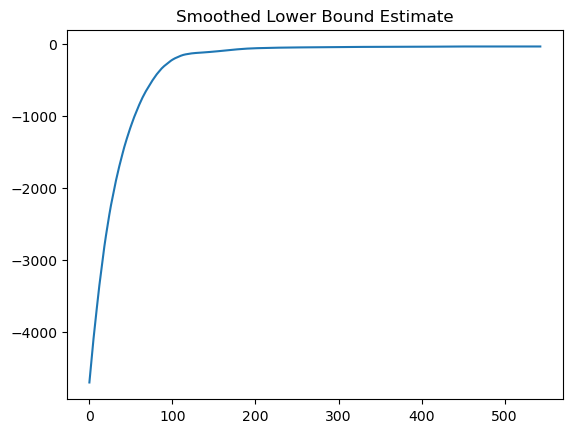

In [25]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [29]:
best_mu = nn_best_lambda[0]
best_vech_l = list(nn_best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = ss_multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.62725343, 34.62215433,  0.60955741])

In [30]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.3849035698413294